In [1]:
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from timm.models.efficientvit_mit import GELUTanh, EfficientVitBlock, ResidualBlock, build_local_block
from pytorch_wavelets import DWTForward, DWTInverse
from tft.transforms import WPT2D, IWPT2D
from tft.utils import compand, decompand
dataset = datasets.load_dataset("danjacobellis/LSDIR")

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [2]:
def _divisors(n):
    divs = []
    i = 1
    while i * i <= n:
        if n % i == 0:
            divs.append(i)
            if i != n // i:
                divs.append(n // i)
        i += 1
    return sorted(divs)

class FactorizedConv2d(nn.Module):
    def __init__(self, in_chs, out_chs, bias=False):
        super().__init__()
        self.in_chs, self.out_chs = in_chs, out_chs
        g1, g2 = self._pick_groups(in_chs, out_chs)
        self.g1, self.g2 = g1, g2
        self.conv1 = nn.Conv2d(in_chs, in_chs, 1, groups=g1, bias=bias)
        self.conv2 = nn.Conv2d(in_chs, out_chs, 1, groups=g2, bias=bias)

    def _pick_groups(self, in_chs, out_chs):
        divs = _divisors(in_chs)
        best_g1, best_g2, best_cost = 1, in_chs, float('inf')
        for d in divs:
            g1, g2 = d, in_chs // d
            cost = (in_chs * in_chs / g1) + (in_chs * out_chs / g2)
            if cost < best_cost:
                best_cost, best_g1, best_g2 = cost, g1, g2
        return best_g1, best_g2

    def forward(self, x):
        x = self.conv1(x)
        x = einops.rearrange(x, 'b (g1 g2) h w -> b (g2 g1) h w', g1=self.g1, g2=self.g2)
        x = self.conv2(x)
        return x

class FixedScaleQuantization(nn.Module):
    def __init__(self, scales):
        super().__init__()
        scales_tensor = torch.tensor(scales, dtype=torch.float32)
        self.register_buffer('scales', scales_tensor)
        self.hardtanh = nn.Hardtanh(min_val=-127.49, max_val=127.49)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            s_half = self.scales.view(1, -1, 1, 1) / 2.0
            noise = (torch.rand_like(x) - 0.5) * 2.0 * s_half
            x = x + noise
            x = self.hardtanh(x)
            return x
        else:
            s_view = self.scales.view(1, -1, 1, 1)
            x = self.hardtanh(x)
            x = x / s_view
            x = torch.round(x)
            return x
            
    def scale(self, x_int: torch.Tensor) -> torch.Tensor:
        s_view = self.scales.view(1, -1, 1, 1)
        x_float = x_int * s_view
        x_float = self.hardtanh(x_float)
        return x_float

class PerChannelNoiseScale(nn.Module):
    def __init__(self, num_channels, total_scale):
        super().__init__()
        self.num_channels = num_channels
        self.alpha = nn.Parameter(torch.zeros(num_channels))
        self.min_scale = 1.0
        self.total_scale = total_scale

    def forward(self):
        exp_alpha = torch.exp(self.alpha)
        alpha_sum = exp_alpha.sum()
        total_excess = (self.total_scale - self.min_scale) * self.num_channels
        S_prime = total_excess * (exp_alpha / alpha_sum)
        return self.min_scale + S_prime

class NoiseInjectionModel(nn.Module):
    def __init__(self, num_channels, total_scale):
        super().__init__()
        self.num_channels = num_channels
        self.noise_scales = PerChannelNoiseScale(num_channels, total_scale)
        self.hardtanh = nn.Hardtanh(min_val=-127.49, max_val=127.49)

    def forward(self, x):
        if self.training:
            S = self.noise_scales()
            S_half = (S / 2.0).view(1, -1, 1, 1)
            noise = (torch.rand_like(x) * 2.0 - 1.0) * S_half
            x = x + noise
            x = self.hardtanh(x)
            return x
        else:
            S = self.noise_scales() 
            S_view = S.view(1, -1, 1, 1)
            x = self.hardtanh(x)
            x = x / S_view
            x = torch.round(x)
            return x

    def scale(self, x_int):
        S = self.noise_scales()
        S_view = S.view(1, -1, 1, 1)
        x_float = x_int * S_view
        x_float = self.hardtanh(x_float)
        return x_float


class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)

class EfficientVitStageNoDS(nn.Module):
    def __init__(self, in_chs, out_chs, depth, norm_layer, act_layer):
        super(EfficientVitStageNoDS, self).__init__()
        blocks = [
            ResidualBlock(
                build_local_block(
                    in_channels=in_chs,
                    out_channels=out_chs,
                    stride=1,
                    expand_ratio=4,
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                    fewer_norm=True,
                    block_type='default'
                ),
                None,
            )
        ]
        in_chs = out_chs
        for _ in range(depth):
            blocks.append(
                EfficientVitBlock(
                    in_channels=in_chs,
                    head_dim=32,
                    expand_ratio=4,
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                )
            )
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)
        
def entropy_code(ints):
    webp_bytes = []
    for sample in ints:
        c_groups = sample.shape[0] // 3
        sample_webp = []
        for g in range(c_groups):
            group = sample[g*3 : g*3+3]
            group = (group + 127).clamp_(0, 255).byte()
            img = ToPILImage()(group)
            buff = io.BytesIO()
            img.save(buff, format='WEBP', lossless=True)
            sample_webp.append(buff.getbuffer())
        webp_bytes.append(sample_webp)
    
    return webp_bytes


def entropy_decode(webp_bytes):
    batch_out = []
    for sample_buffers in webp_bytes:
        group_tensors = []
        for buff in sample_buffers:
            with io.BytesIO(buff) as memfile:
                img = PIL.Image.open(memfile).convert('RGB')
            t = PILToTensor()(img).to(torch.int16) - 127
            group_tensors.append(t)
        sample_tensor = torch.cat(group_tensors, dim=0)
        sample_tensor = sample_tensor.unsqueeze(0)
        batch_out.append(sample_tensor)
    decoded = torch.cat(batch_out, dim=0)
    return decoded

In [8]:
class AutoEncoder2D(nn.Module):
    def __init__(self, channels, J, latent_dim, levels_per_channel):
        super().__init__()
        self.J=J
        self.latent_dim=latent_dim
        self.wt = DWTForward(J=1, mode='periodization', wave='bior4.4')
        self.wpt = WPT2D(wt=self.wt, J=J)
        self.conv_down = FactorizedConv2d(channels*(4**J), latent_dim, bias=False)
        self.noise_injection = FixedScaleQuantization([256/L for L in levels_per_channel])
        self.conv_up = nn.Conv2d(latent_dim, channels*(4**J), kernel_size=1, padding=0, bias=False)
        self.vit =  EfficientVitStageNoDS(
            in_chs = channels*(4**J),
            out_chs = channels*(4**J),
            depth = 6,
            norm_layer=GroupNorm8,
            act_layer=GELUTanh,
        )
        self.iwt =  DWTInverse(mode='periodization', wave='bior4.4')
        self.iwpt = IWPT2D(iwt=self.iwt,J=J)

    def encode(self, x):
        x = self.wpt(x)
        x = 12.8*compand(x, power=0.4)
        x = self.conv_down(x)
        x = self.noise_injection(x)
        return x

    def decode_train(self, x):
        x = self.conv_up(x)
        x = self.vit(x)
        x = decompand(x/12.8, power=0.4)
        x = self.iwpt(x)
        return x
        
    def forward(self, x):
        x = self.decode_train(self.encode(x))
        return x
        
    def decode(self, x):
        x = self.noise_injection.scale(x)
        x = self.conv_up(x)
        x = self.vit(x)
        x = decompand(x/12.8, power=0.4)
        x = self.iwpt(x)
        return x

In [9]:
config = SimpleNamespace()
config.F = 16
config.levels_per_channel = [31] + 3*[15] + 4*[7] + 4*[3]
config.latent_dim = 12;
config.channels = 3
config.max_noise_penalty = 1e-3
config.max_lr = 1e-3
config.min_lr = config.max_lr / 1e3
config.lr_pow = 2
config.img_size = 224
config.batch_size = 64
config.num_workers = 32
config.epochs = 24
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)

In [10]:
model = AutoEncoder2D(
    channels=config.channels,
    J = int(config.F**0.5),
    latent_dim=config.latent_dim,
    levels_per_channel=config.levels_per_channel
).to(device)

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

51.783936 M parameters


In [11]:
def collate_fn(batch):
    return torch.cat([
        PILToTensor()(
            RandomCrop(config.img_size)(sample['image'])
        ).unsqueeze(0) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=collate_fn
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        x_hat = model(x)
     
        loss = torch.nn.functional.mse_loss(x, x_hat) 
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
    
        pb.comment = f"PSNR: {-10*np.log10(losses[-1])+6.02:.3g}, LR: {learning_rates[-1]:.3g}"

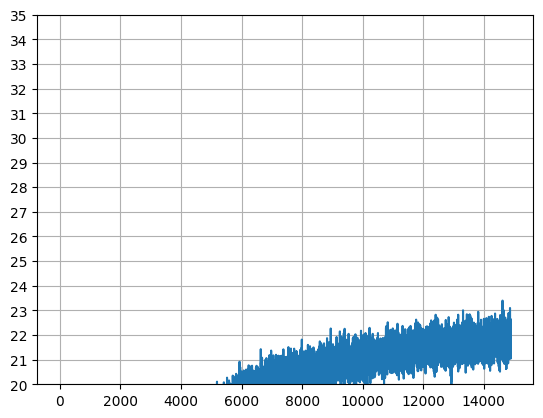

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
plt.plot(-10*np.log10(losses)+6.02)
plt.yticks(range(20,36));
plt.ylim([20,35])
plt.grid()

3.98 KB
197.59597989949748x compression ratio
64.0x dimension reduction
18.214576263427734 dB PSNR


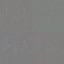

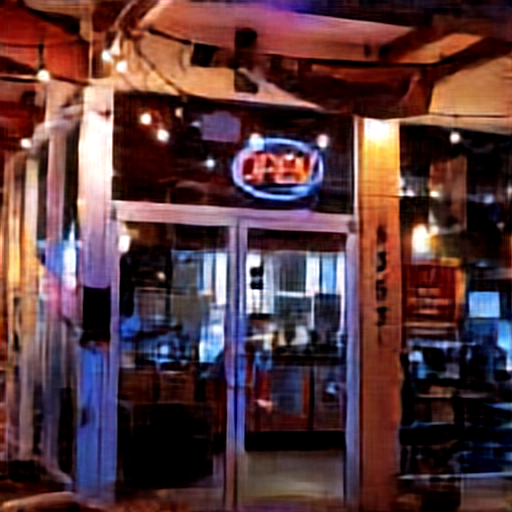

In [33]:
from walloc.walloc import latent_to_pil, pil_to_latent
model.eval()
config.img_size=512
img = CenterCrop(config.img_size)(dataset['validation'][28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()
with torch.no_grad():
    latent = model.encode(x)
webp = latent_to_pil(latent.cpu(),n_bits=8, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")
latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
with torch.no_grad():
    x_hat = model.decode(latent_decoded)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

display(webp[0])
ToPILImage()(x_hat[0].clamp(-1,1)/2+0.5)

(120.0, 134.0)

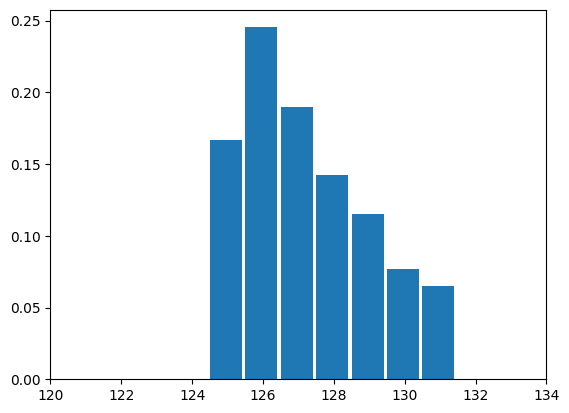

In [12]:
plt.hist(np.array(webp[0]).flatten(),bins=256,range=(-0.5,255.5),width=0.9,density=True);
plt.xlim([127-7,127+7])

In [35]:
model.noise_injection.noise_scales()

tensor([36.6050, 36.5555, 36.5667, 36.5781, 36.5526, 36.5584, 36.5844, 36.5753,
        36.5892, 36.5570, 36.5533, 36.5816], device='cuda:0',
       grad_fn=<AddBackward0>)

TypeError: cannot assign 'torch.DoubleTensor' as child module 'noise_scales' (torch.nn.Module or None expected)

tensor(2.8074)


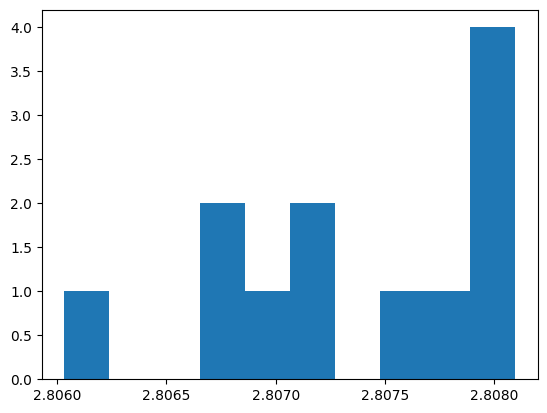

In [13]:
bits_per_channel = (8 - model.noise_injection.noise_scales().detach().log2()).cpu()
print(bits_per_channel.mean())
plt.hist(bits_per_channel);

24.12344741821289 PSNR
8.0K	test.webp


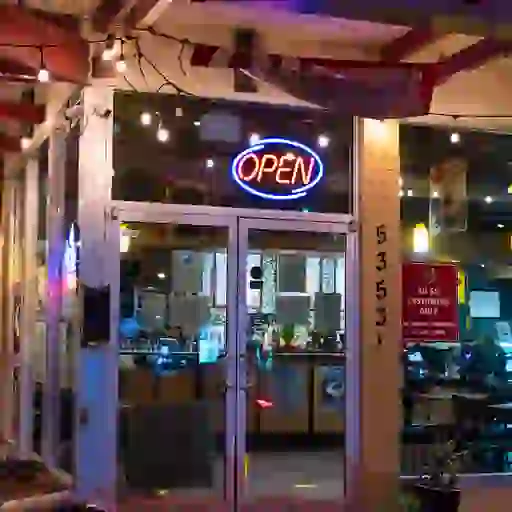

In [15]:
img.crop((0,0,config.img_size,config.img_size)).save("test.webp",quality=0)
webp = PIL.Image.open("test.webp")
MSE = torch.nn.functional.mse_loss(PILToTensor()(jpeg).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.webp
display(webp)